In [2]:
#to avoid trouble with accelerate later on!
#pip uninstall transformer_engine -y

In [4]:
!nvidia-smi

Tue Nov 28 17:52:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   44C    P0              62W / 400W |  13614MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Set up lmql model

In [ ]:
import lmql

model = lmql.model(
    "local:HuggingFaceH4/zephyr-7b-alpha",
    device_map = "auto",
    load_in_8bit=True,
    low_cpu_mem_usage=True
)


## LMQL Queries

In [ ]:
@lmql.query
async def init(stance, topic, n=1):
    '''lmql
    sample(temperature=0.9)
      "<|user|>\n"
      "# Provide a claim that corresponds to a given stance\n\n"
      "Alice is going to debate '{topic}'.\n"
      "For the purpose of the debate, she'll initially adopt a claim that is {stance} {topic}.\n\n"
      "Can you please suggest {n} such claims?\n\n"
      "State each claim in a single sentence, keeping it short an concise. "
      "Make sure you provide sufficiently diverse claims.\n"
      "<|assistant|>\n"
      "Alice might defend one of the following claims:\n"
      claims = []
      for _ in range(n):
        "  * \"[OPINION]\"\n" where STOPS_AT(OPINION, ".") and STOPS_AT(OPINION, "!") and STOPS_AT(OPINION, '"') and len(OPINION)<160
        claims.append(OPINION)
      return claims
    '''


@lmql.query
async def revise(opinion, peer_opinions, self_confidence, topic):
    '''lmql
    sample(temperature=0.6)
      "<|user|>\n"
      "# Recommend whether and how to revise an opinion"
      "Alice has been debating '{topic}'.\n"
      "She has previously held the following opinion.\n\n"
      "Alice: \"{opinion}\"\n\n"
      "Now, through debating '{topic}', she has learned that her peers maintain the following views:\n"
      for peer_opinion in peer_opinions:
        "- {peer_opinion}\n"
      "\n"
      "Alice considers her peers trustworthy and reliable.\n"
      "Alice has {self_confidence} confidence in her previously held opinion and accordingly {self_confidence} resistance to changing her opinion.\n\n"
      "This being said, which opinion will Alice adopt in the future, having heard about her peers' views?\n"
      "1. Repeat Alice's previously held opinion.\n"
      "2. State Alice's future opinion in a single sentence, keeping it short an concise.\n"
      "<|assistant|>\n"
      "1. Alice's previous opinion: \"{opinion}\"\n"
      "2. Alice's future opinion: \"[REVISION]" where STOPS_AT(REVISION, ".") and STOPS_AT(REVISION, "!") and STOPS_AT(REVISION, '"') and len(REVISION)<240
    '''

#       "What's a compromise position that balances Alice's opinion and those of her peers? State the compromise in a single sentence, keeping it "


@lmql.query
async def agreement(opinion):
    '''lmql
    argmax
      "<|user|>\n"
      "# Assess perceived expertise\n\n"
      "Suppose Alice and Bob are debating 'veganism'.\n"
      "They hold the following opinions.\n\n"
      "Alice: It's outright irresponsible to eat meat.\n\n"
      "Bob: {opinion}\n\n"
      "Given these opinions, is Alice prepared to listen to what Bob has to say and take his view into account when revising her beliefs?\n"
      "To address this question, let's assess how similar Bob's and Alice's opinions are:"
      "(A) very similiar\n"
      "(B) somewhat similar\n"
      "(C) neutral\n"
      "(D) somewhat opposing\n"
      "(E) strongly opposing\n"
      "Just answer with A/B/C/D/E (you'll be asked to explain your answer later on)."
      "<|assistant|>\n"
      "[LABEL]"
    where
      LABEL in ["A","B","C","D","E"]
    '''

In [ ]:
await agreement("I think it's ok to eat a nice cheese cake from time to time.", model=model)

In [ ]:
await agreement("I think it's ok to eat a nice burger every day.", model=model)

In [ ]:
await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I think it's ok to eat a nice burger every day.",
        "I think it's ok to eat a nice cheese cake from time to time.",
    ],
    topic="veganism",
    self_confidence="extremely high",
    model=model
)

In [ ]:
await revise(
    opinion="It's outright irresponsible to eat meat.",
    peer_opinions=[
        "I never eat meat, not even dietary products.",
        "I think it's ok to eat a nice cheese cake from time to time.",
        "It's outright irresponsible to eat meat.",
        "It's outright irresponsible to eat meat.",
    ],
    topic="veganism",
    self_confidence="extremely high",
    model=model
)

In [ ]:
await init(
    topic="veganism",
    stance="loosely related to",
    n=3,
    model=model
)

## Skeleton BC Model

In [7]:
import copy
import numpy as np
import random
import uuid

In [8]:
class AbstractBCAgent():

    def __init__(self, initial_opinion, **kwargs):
        self.opinion = initial_opinion
        self._step = 0
        self._parameters = kwargs
        self.uid = str(uuid.uuid4())

    def update(self, community):
        """updates agent state"""
        peers = self.peers(community)
        opinions = [peer.opinion for peer in peers]
        self.opinion = self.revise(opinions)
        self._step += 1

    def peers(self, community):
        """returns agents with opinion distance smaller than epsilon"""
        epsilon = self._parameters.get("epsilon", .1)
        peers = [
            agent for agent in community
            if self.distance(agent.opinion) <= epsilon and
            agent.uid != self.uid
        ]
        return peers

    def distance(self, opinion):
        """calculates distance between agent's and other opinion"""

    def revise(self, opinions):
        """revises agent's opinion given opinions (of peers)"""

    def log_state(self):
        """agent state for logging"""
        return {"uid": self.uid, "opinion": self.opinion}


In [9]:
class EpistemicCommunity():

    def __init__(self, agents: list[AbstractBCAgent]):
        self.agents = agents
        self.logs = []
        self.log(0)

    def interact(self, max_steps=10):
        for step in range(max_steps):
            agents_snapshot = copy.deepcopy(self.agents)
            for agent in self.agents:
                agent.update(agents_snapshot)
            self.log(step+1)

    def log(self, step):
        self.logs.append({
            "step": step,
            "agents": [agent.log_state() for agent in self.agents]
        })

## Numerical BC Model

In [10]:
class NumericalBCAgent(AbstractBCAgent):

    def distance(self, opinion):
        """calculates distance between agent's and other opinion"""
        return abs(opinion - self.opinion)

    def revise(self, opinions):
        """revision through weighted opinion averaging"""
        alpha = self._parameters.get("alpha", .5)
        revision = alpha * self.opinion + (1-alpha) * np.mean(opinions)
        return revision

In [11]:
N = 23
community = EpistemicCommunity([
    NumericalBCAgent(
        random.random(),
        alpha=.5,
        epsilon=.2
    ) for _ in range(N)
])

In [12]:
community.interact()

In [15]:
import pandas as pd
df_opinions = pd.DataFrame(community.logs).explode(["agents"])
df_opinions = pd.concat([
    df_opinions.step,
    df_opinions.agents.apply(pd.Series)
], axis=1)

<Axes: xlabel='step', ylabel='opinion'>

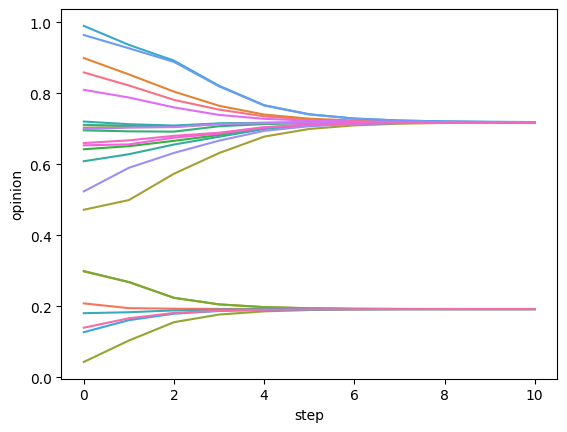

In [16]:
import seaborn as sns

sns.lineplot(df_opinions, x="step", y="opinion", hue="uid", legend=False)